In [10]:
# remove warning message
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# required library
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from utils import detect_lp
from os.path import splitext,basename
from tensorflow.keras.models import model_from_json
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.preprocessing import LabelEncoder
import glob
from skimage.filters import threshold_local
from skimage import measure
import imutils

from matplotlib import pyplot

### Part 1: Extract license plate from sample image

In [11]:
def load_model(path):
    try:
        path = splitext(path)[0]
        with open('%s.json' % path, 'r') as json_file:
            model_json = json_file.read()
        model = model_from_json(model_json, custom_objects={})
        model.load_weights('%s.h5' % path)
        print("Loading model successfully...")
        return model
    except Exception as e:
        print(e)

In [12]:
wpod_net_path = "wpod-net.json"
wpod_net = load_model(wpod_net_path)

Loading model successfully...


In [13]:
# Load model architecture, weight and labels
json_file = open('MobileNets_character_recognition.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights("License_character_recognition_weight.h5")
print("[INFO] Model loaded successfully...")

lb = LabelEncoder()
lb.classes_ = np.load('license_character_classes.npy')
print("[INFO] Labels loaded successfully...")

[INFO] Model loaded successfully...
[INFO] Labels loaded successfully...


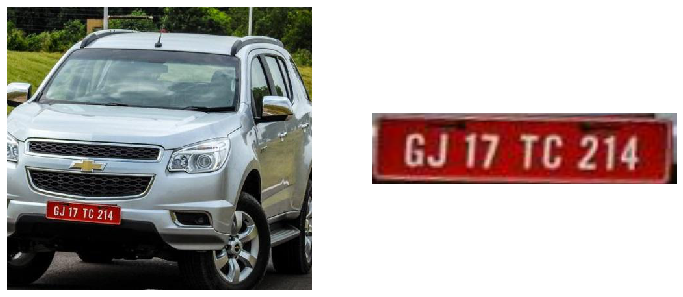

In [182]:
def preprocess_image(image_path,resize=False):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255
    if resize:
        img = cv2.resize(img, (224,224))
    return img

def get_plate(image_path):
    Dmax = 608
    Dmin = 288
    vehicle = preprocess_image(image_path)
    ratio = float(max(vehicle.shape[:2])) / min(vehicle.shape[:2])
    side = int(ratio * Dmin)
    bound_dim = min(side, Dmax)
    _ , LpImg, _, cor = detect_lp(wpod_net, vehicle, bound_dim, lp_threshold=0.5)
    return vehicle, LpImg, cor

image_paths = glob.glob("test/*.jpeg")

test_image_path = "test/licensed_car52.jpeg"
#test_image_path = "Plate_examples/licensed_car21.jpeg"
vehicle, LpImg,cor = get_plate(test_image_path)

fig = plt.figure(figsize=(12,6))
grid = gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[0])
plt.axis(False)
plt.imshow(vehicle)
grid = gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[1])
plt.axis(False)
for lp in LpImg:
    plt.imshow(lp)

## Part 2: Segementing license characters

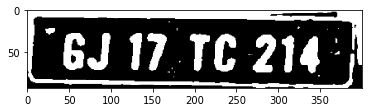

(93, 400)


In [184]:
#image = cv2.imread('./op/23.png')
#plt.imshow(image)
#plt.show()
#image = cv2.imread('./ml.jpeg')
image = 1-cv2.convertScaleAbs(LpImg[0], alpha=(255.0))
#image = cv2.cvtColor(LpImg[0],cv2.COLOR_RGB2BGR)
V = cv2.split(cv2.cvtColor(image, cv2.COLOR_RGB2HSV))[2]
blur = cv2.GaussianBlur(V,(3,3),0)
_,thresh = cv2.threshold(blur,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
#T = threshold_local(V, 29, offset=15, method="gaussian")
#thresh = (V > T).astype("uint8") * 255
#thresh = cv2.bitwise_not(thresh)

# resize the license plate region to a canonical size
plate = imutils.resize(image, width=400)
binary = imutils.resize(thresh, width=400)
#cv2.imshow("Thresh", thresh)
plt.imshow(binary,cmap='gray')
plt.show()
print(binary.shape)


[54, 110, 128, 253]


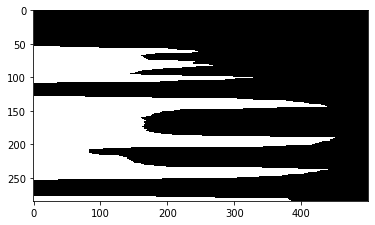

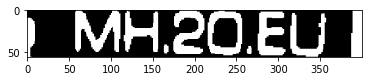

In [177]:
tl = []
val = 100000
proj = np.sum(binary,axis = 1)

m = np.max(proj)
w = 500

result = np.zeros((proj.shape[0],500))
p = [int(proj[row]*w/m)-50 for row in range(len(proj))]


neg = False
points = []
start=-1
end=-1
for i in range(len(p)):
    if neg == False:
        if(p[i]<0):
            neg = True
            start = i
            break
neg = False
for i in range(len(p)-1,-1,-1):
    if neg == False:
        if(p[i]<0):
            neg = True
            end = i
            break
neg = True
for i in range(start,end+1):
    if neg and p[i]>0:
        points.append(i)
        neg = False
    elif neg==False and p[i]<0:
        points.append(i)
        neg = True
print(points)
        


# Draw a line for each row
for row in range(binary.shape[0]):
    #pp.append()
    #v = int(proj[row]*w/m),row)
    #if v in range(50,200)
    cv2.line(result, (0,row), (int(proj[row]*w/m)-50,row), (255,255,255), 1)
    #print(int(proj[row]*w/m),row)

# Save result
plt.imshow(result,cmap='gray')
plt.show()

#bc1 = binary[points[4]:points[5],:]
#plt.imshow(bc1,cmap='gray')
#plt.show()
bc2 = binary[points[0]:points[1],:]
plt.imshow(bc2,cmap='gray')
plt.show()
#cv2.imwrite('result.png', result)

(400,)


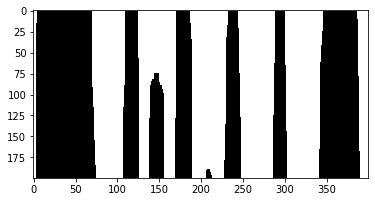

In [51]:
proj = np.sum(bc2
              ,axis = 0)
print(proj.shape)
m = np.max(proj)
w = 500
result = np.zeros((200,proj.shape[0]))

# Draw a line for each row
for row in range(binary.shape[1]):
   cv2.line(result,(row,int(proj[row]*w/m)),(row,0), (255,255,255), 1)

# Save result
plt.imshow(result,cmap='gray')
plt.show()
#cv2.imwrite('result.png', result)

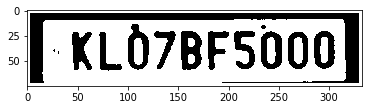

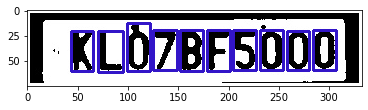

In [13]:

crop_characters = segment_characters(image)

#plt.savefig("segmented_leter.png",dpi=300)    

In [62]:
labels = measure.label(thresh, connectivity=2, background=0)
charCandidates = np.zeros(thresh.shape, dtype="uint8")
crop_characters = []
for label in np.unique(labels):
    # if this is the background label, ignore it
    if label == 0:
        continue
    # otherwise, construct the label mask to display only connected components for the
    # current label, then find contours in the label mask
    labelMask = np.zeros(thresh.shape, dtype="uint8")
    labelMask[labels == label] = 255
    cnts = cv2.findContours(labelMask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if imutils.is_cv2() else cnts[1]
    #cnts = sort_contours(cnts)
    if len(cnts) > 0:
        # grab the largest contour which corresponds to the component in the mask, then
        # grab the bounding box for the contour
        c = max(cnts, key=cv2.contourArea)
        (boxX, boxY, boxW, boxH) = cv2.boundingRect(c)
        # compute the aspect ratio, solidity, and height ratio for the component
        aspectRatio = boxW / float(boxH)
        solidity = cv2.contourArea(c) / float(boxW * boxH)
        heightRatio = boxH / float(plate.shape[0])

        # determine if the aspect ratio, solidity, and height of the contour pass
        # the rules tests
        keepAspectRatio = aspectRatio < 1.0
        keepSolidity = solidity > 0.15
        keepHeight = heightRatio > 0.4 and heightRatio < 0.95

        # check to see if the component passes all the tests
        if keepAspectRatio and keepSolidity and keepHeight:
            # compute the convex hull of the contour and draw it on the character
            # candidates mask
            #cv2.rectangle(thresh, (boxX, boxY), (boxX + boxW, boxY + boxH), (0, 255,0), 2)
            curr_num = thresh[boxY:boxY+boxH,boxX:boxX+boxW]
            curr_num = cv2.resize(curr_num, dsize=(30, 60))
            _, curr_num = cv2.threshold(curr_num, 220, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            crop_characters.append([curr_num,boxX])

#charCandidates = segmentation.clear_border(charCandidates)
#plt.imshow(thresh)
#plt.imshow(image)

In [46]:
'''if (len(LpImg)): #check if there is at least one license image
    # Scales, calculates absolute values, and converts the result to 8-bit.
    plate_image = cv2.convertScaleAbs(LpImg[0], alpha=(255.0))
    
    # convert to grayscale and blur the image
    gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)
    blur = gray#cv2.GaussianBlur(gray,(7,7),0)
    
    # Applied inversed thresh_binary 
    binary = cv2.threshold(blur, 180, 255,
                         cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
        
    kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    #binary = cv2.erode(binary,(7,7))
    #binary = cv2.dilate(binary,kernel3)
    thre_mor = cv2.morphologyEx(binary, cv2.MORPH_DILATE, kernel3)

    
# visualize results    
fig = plt.figure(figsize=(12,7))
plt.rcParams.update({"font.size":18})
grid = gridspec.GridSpec(ncols=2,nrows=3,figure = fig)
plot_image = [plate_image, gray, blur, binary,thre_mor]
plot_name = ["plate_image","gray","blur","binary","dilation"]

for i in range(len(plot_image)):
    fig.add_subplot(grid[i])
    plt.axis(False)
    plt.title(plot_name[i])
    if i ==0:
        plt.imshow(plot_image[i])
    else:
        plt.imshow(plot_image[i],cmap="gray")

# plt.savefig("threshding.png", dpi=300)'''

'if (len(LpImg)): #check if there is at least one license image\n    # Scales, calculates absolute values, and converts the result to 8-bit.\n    plate_image = cv2.convertScaleAbs(LpImg[0], alpha=(255.0))\n    \n    # convert to grayscale and blur the image\n    gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)\n    blur = gray#cv2.GaussianBlur(gray,(7,7),0)\n    \n    # Applied inversed thresh_binary \n    binary = cv2.threshold(blur, 180, 255,\n                         cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]\n        \n    kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))\n    #binary = cv2.erode(binary,(7,7))\n    #binary = cv2.dilate(binary,kernel3)\n    thre_mor = cv2.morphologyEx(binary, cv2.MORPH_DILATE, kernel3)\n\n    \n# visualize results    \nfig = plt.figure(figsize=(12,7))\nplt.rcParams.update({"font.size":18})\ngrid = gridspec.GridSpec(ncols=2,nrows=3,figure = fig)\nplot_image = [plate_image, gray, blur, binary,thre_mor]\nplot_name = ["plate_image","gray"

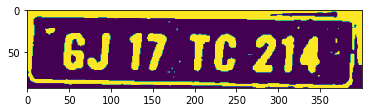

Detect 11 letters...


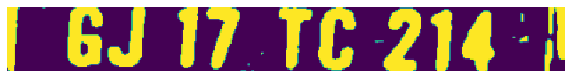

In [171]:
plt.imshow(binary)
plt.show()
# Create sort_contours() function to grab the contour of each digit from left to right
def sort_contours(cnts,reverse = False):
    i = 0
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
                                        key=lambda b: b[1][i], reverse=reverse))
    return cnts

#binary = cv2.Canny(binary,200,300)
#plt.imshow(binary)
_, cont, _  = cv2.findContours(bc2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#img = cv2.drawContours(binary, cont, -1, (0,0,0), 3)
#plt.imshow(img,cmap='gray')
#plt.show()
plate_image = bc2
# creat a copy version "test_roi" of plat_image to draw bounding box
test_roi = plate_image.copy()

# Initialize a list which will be used to append charater image
crop_characters = []

# define standard width and height of character
digit_w, digit_h = 30, 60

for c in sort_contours(cont):
    (x, y, w, h) = cv2.boundingRect(c)
    ratio = h/w
    if 1<=ratio<=3.5: # Only select contour with defined ratio
        if h/plate_image.shape[0]>=0.5: # Select contour which has the height larger than 50% of the plate
            # Draw bounding box arroung digit number
            #cv2.rectangle(test_roi, (x, y), (x + w, y + h), (0, 255,0), 2)
            
            # Sperate number and gibe prediction
            curr_num = bc2[y:y+h,x:x+w]
            curr_num = cv2.resize(curr_num, dsize=(digit_w, digit_h))
            _, curr_num = cv2.threshold(curr_num, 220, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            crop_characters.append(curr_num)

print("Detect {} letters...".format(len(crop_characters)))
fig = plt.figure(figsize=(10,6))
plt.axis(False)
plt.imshow(test_roi)
#plt.savefig('grab_digit_contour.png',dpi=300)

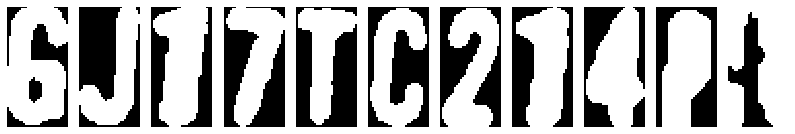

In [172]:
fig = plt.figure(figsize=(14,4))
grid = gridspec.GridSpec(ncols=len(crop_characters),nrows=1,figure=fig)

for i in range(len(crop_characters)):
    #print(crop_characters[i][1])
    fig.add_subplot(grid[i])
    plt.axis(False)
    plt.imshow(crop_characters[i],cmap="gray")
#plt.savefig("segmented_leter.png",dpi=300)    

## Load pre-trained MobileNets model and predict

In [165]:
# pre-processing input images and pedict with model
def predict_from_model(image,model,lb):
    image = cv2.resize(image,(80,80))
    image = np.stack((image,)*3, axis=-1)
    prediction = lb.inverse_transform([np.argmax(model.predict(image[np.newaxis,:]))])
    return prediction

6J17TC214T3


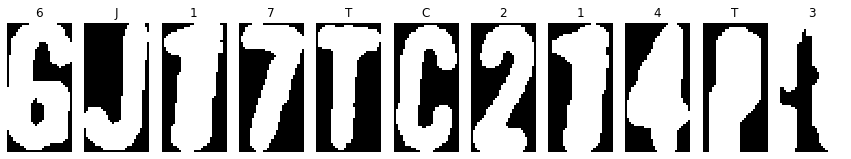

In [173]:
fig = plt.figure(figsize=(15,3))
cols = len(crop_characters)
grid = gridspec.GridSpec(ncols=cols,nrows=1,figure=fig)

final_string = ''
for i,character in enumerate(crop_characters):
    fig.add_subplot(grid[i])
    title = np.array2string(predict_from_model(character,model,lb))
    plt.title('{}'.format(title.strip("'[]"),fontsize=20))
    final_string+=title.strip("'[]")
    plt.axis(False)
    plt.imshow(character,cmap='gray')

print(final_string)
#plt.savefig('final_result.png', dpi=300)
pyplot.imsave(final_string+'.png',LpImg[0])

# The end!